# 感興趣的Twitter帳號
### 將前 20 位最多 follower 的帳號作為「興趣對象」，把所有發過的 Tweets 文字轉換為 list 元素，再從 list 當中找出最常出現的單字。
#### 文字擷取
##### http://stackoverflow.com/questions/10390989/python-program-that-finds-most-frequent-word-in-a-txt-file-must-print-word-and
##### http://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
##### http://stackoverflow.com/questions/5239781/finding-the-most-popular-words-in-a-list
#### 決策樹
##### http://www.jianshu.com/p/c8f1f516e9ea
##### https://zhuanlan.zhihu.com/p/20794583

# 將 2-(g) 的指標帳號分析結果存為 id

In [60]:
import pyes
es_address='127.0.0.1:9200'

conn = pyes.es.ES(es_address)

q = pyes.query.MatchAllQuery()
sfc = list()
dfc = dict()

result = conn.search(query=q , indices='twitter2' , doc_types='user') 

for x in result:
    
    # 將使用者名稱與 followers_count 編入 dict。
    if x['followers_count'] in dfc:
        dfc[x['followers_count']].append(x['uid'])
    else:
        dfc[x['followers_count']] = [x['uid']]
        
    # 將所有使用者的 follower 數量拉出來等待排序。
    sfc.append(x['followers_count']) 

sfc.sort(reverse=True) # 將 list 排序。


print "Top 20 user's id:"
for y in range(20): # 前 20 名的帳號 id。
    print "".join(str(dfc[sfc[y]])[1:-1]) # 將排序的id資料從dict取出，轉換為string，拿掉中括弧，最後將list轉換為string。

Top 20 user's id:
14666934
297856522
23566038
22790881
18789893
18476766
19206209
14669471
14181505
65845659
14924745
16730420
8917142
64677310
11791512
198365324
38956896
48443
17767238
14293266


# 將分析結果中第 1 名帳號之所有貼文拉下來並拆成文字

In [102]:
AllWords = list()

q = pyes.query.BoolQuery() # BoolQuery本身是一個Query的組合，可以使用add_must(), add_must_not(), add_should()來使用。

tq = pyes.query.TermQuery(field="uid", value="".join(str(dfc[sfc[0]])[1:-1]))
q.add_must(tq)

result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 

for z in result: # 將所有string切成list
    AllWords = AllWords + z['text'].split()
    
for a in range(0, len(AllWords)): # 將list中的元素解碼(去除u'[])
    AllWords[a] = AllWords[a].encode('utf-8')

print AllWords

['.@Authentic8', 'really', 'bad', 'policy', 'as', 'that', 'is', 'so', 'subjective.', '.@Authentic8', 'Hey,', 'look', 'at', 'your', 'privacy', 'policy.', 'It', 'may', 'need', 'an', 'update', 'because', 'it', 'clearly', 'says:', "'", '...', 'that', 'may', 'be', 'considered', '..', 'unethical.."', 'The', 'LastPass', 'demo', 'was', 'shown', 'at', 'Derbycon.', "It's", 'really', 'no', 'big', 'deal', 'once', 'you', 'get', 'system', 'privs.', '1Password', 'was', 'easier.', 'https://t.co/e9Zr09sHMc', '.@htilonom', '@janwinter15', '@claushoumann', 'No,', 'but', 'the', 'vault', 'should', 'be', 'a', 'standalone', 'hardened', 'machine.', 'I', 'think', 'the', 'best', 'way', 'for', 'the', 'average', 'Joe', 'to', 'mitigate', 'malware', 'is', 'to', 'use', 'OSX', 'and', 'only', 'allow', 'applications', 'from', "Mac's", 'App', 'Store.', 'Now', 'I', 'am', 'afraid', 'to', 'start', 'reading', 'more', 'of', 'these', '"privacy"', 'policies.', 'I', "don't", 'think', 'they', 'are', 'the', 'only', 'one', 'with',

# 找出句子中出現次數最多的前 10 個單字

In [104]:
from collections import Counter

words_to_count = (word for word in AllWords if word[:1].isupper())
c = Counter(words_to_count)
print c.most_common(10)

[('I', 1027), ('RT', 545), ('The', 211), ('LOL', 206), ('NSA', 150), ('Snowden', 124), ('Just', 106), ('If', 80), ('So', 80), ('You', 78)]


# 將前 20 個帳號之所有貼文拉下來分析「共通的」前 20 名單字

In [129]:
import pyes
from collections import Counter

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

mq = pyes.query.MatchAllQuery()
sfc = list()
dfc = dict()

result = conn.search(query=mq , indices='twitter2' , doc_types='user') 

for x in result:
    
    # 將使用者名稱與 followers_count 編入 dict。
    if x['followers_count'] in dfc:
        dfc[x['followers_count']].append(x['uid'])
    else:
        dfc[x['followers_count']] = [x['uid']]
        
    # 將所有使用者的 follower 數量拉出來等待排序。
    sfc.append(x['followers_count']) 

sfc.sort(reverse=True) # 將 list 排序。


AllUserAllWords = list()
for u in range(20):
    q = pyes.query.BoolQuery() # BoolQuery本身是一個Query的組合，可以使用add_must(), add_must_not(), add_should()來使用。
    AllWords = list()
    tq = pyes.query.TermQuery(field="uid", value="".join(str(dfc[sfc[u]])[1:-1]))
    q.add_must(tq)

    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 

    for z in result: # 將所有string切成list
        AllWords = AllWords + z['text'].split()

    for a in range(len(AllWords)): # 將list中的元素解碼(去除u'[])
        AllWords[a] = AllWords[a].encode('utf-8')

    AllUserAllWords = AllUserAllWords + AllWords
        
words_to_count = (word for word in AllUserAllWords if word[:1].isupper())
c = Counter(words_to_count)
print c.most_common(40)

[('RT', 12612), ('I', 9747), ('The', 4601), ('Security', 3076), ('New', 1552), ('How', 1495), ('US', 1391), ("I'm", 1338), ('A', 1329), ('This', 1194), ('You', 1143), ('If', 1115), ('Google', 1082), ('We', 1060), ('ISO', 1054), ('NSA', 1039), ('What', 983), ('It', 888), ('Facebook', 836), ("It's", 804), ('In', 798), ('Affairs', 732), ('Internet', 640), ('My', 635), ('Just', 607), ('Apple', 600), ('FBI', 597), ('Microsoft', 595), ('From', 585), ('Thanks', 575), ('Cyber', 559), ('Twitter', 553), ('Squid', 549), ('Not', 545), ('Is', 538), ('Data', 529), ('Your', 524), ('Android', 522), ('No', 517), ('Amazon', 496)]


##### 結論：採用 Security、ISIS、Terrorism、ISO 4 個字詞
將使用者分類為「Security（資安專家）」、「News_follower（新聞關注者）」、「Standard_Organization（國際標準化組織）」3 個標籤 (Class)。

# 將文字資料整理至表格

In [139]:
import pandas as pd
import pyes
from collections import Counter

es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

mq = pyes.query.MatchAllQuery()
sfc = list()
dfc = dict()

security = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
isis = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
terrorism = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
iso = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label = ['Security', 'Security', 'Security', 'Security', 'Security',
         'News_follower', 'Security', 'News_follower', 'Security', 'Security', 
         'Security', 'Security', 'Standard_Organization', 'Standard_Organization', 'News_follower', 
         'Security', 'Security', 'Security', 'Security', 'Security', ]

result = conn.search(query=mq , indices='twitter2' , doc_types='user') 

for x in result:
    
    # 將使用者名稱與 followers_count 編入 dict。
    if x['followers_count'] in dfc:
        dfc[x['followers_count']].append(x['uid'])
    else:
        dfc[x['followers_count']] = [x['uid']]
        
    # 將所有使用者的 follower 數量拉出來等待排序。
    sfc.append(x['followers_count']) 

sfc.sort(reverse=True) # 將 list 排序。


for u in range(20):
    q = pyes.query.BoolQuery() # BoolQuery本身是一個Query的組合，可以使用add_must(), add_must_not(), add_should()來使用。
    AllWords = list()
    tq = pyes.query.TermQuery(field="uid", value="".join(str(dfc[sfc[u]])[1:-1]))
    q.add_must(tq)

    result = conn.search(query=q , indices='twitter2' , doc_types='tweet') 

    for z in result: # 將所有string切成list
        AllWords = AllWords + z['text'].split()

    for a in range(len(AllWords)): # 將list中的元素解碼(去除u'[])
        AllWords[a] = AllWords[a].encode('utf-8')

    words_to_count = (word for word in AllWords if word[:1].isupper())
    c = Counter(words_to_count)
    security[u] = c['Security']
    isis[u] = c['ISIS']
    terrorism[u] = c['Terrorism']
    iso[u] = c['ISO']

s0 = pd.Series(security, name = 'Security')
s1 = pd.Series(isis, name = 'ISIS')
s2 = pd.Series(terrorism, name = 'Terrorism')
s3 = pd.Series(iso, name = 'ISO')
s4 = pd.Series(label, name = 'Class')
barResult = pd.concat([s0, s1, s2, s3, s4], axis=1)
print barResult

    Security  ISIS  Terrorism   ISO                  Class
0         13     0          0     0               Security
1         61     1          0     0               Security
2         12     3          0     0               Security
3         23     0          0     0               Security
4         54     0          1     0               Security
5        269     3         22     0          News_follower
6        244     0          0     0               Security
7         41    12          0     0          News_follower
8         55     1          0     0               Security
9         22     0          0     0               Security
10        32     0          0     0               Security
11       168     1          0     0               Security
12        14     3          1     6  Standard_Organization
13      1555     9          2  1044  Standard_Organization
14        72    10          0     0          News_follower
15       175     1          0     0               Securi

# 決策樹

Best score: 0.8
Best parameters: {'max_features': 1, 'max_depth': 1}


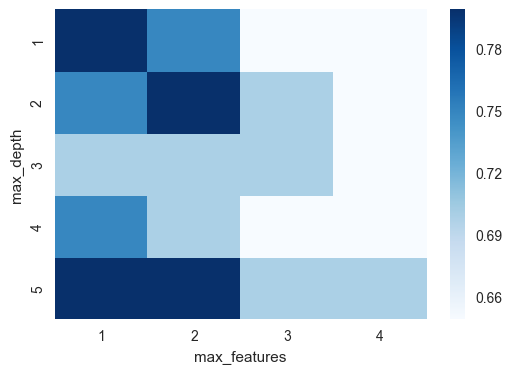

In [160]:
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import seaborn as sb
import matplotlib.pyplot as plt

# We can extract the data in this format from pandas like this:
all_inputs = barResult[['Security', 'ISIS',
                        'Terrorism', 'ISO']].values

# Similarly, we can extract the classes
all_classes = barResult['Class'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, random_state=1)

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

# Heat Map